In [1]:
import matplotlib as mpl
mpl.use("pgf")

## TeX preamble
pgf_with_pdflatex = {
    "font.family": "serif",
    "text.usetex": True,
    "text.latex.unicode": True,
    "pgf.texsystem": "pdflatex",
    "pgf.preamble": [
         r"\usepackage[utf8x]{inputenc}",
         r"\usepackage[T1]{fontenc}",
         r"\usepackage[]{libertine}"
         r"\usepackage[libertine]{newtxmath}"
         ]
}
mpl.rcParams.update(pgf_with_pdflatex)

mpl.rcParams['font.family'] = 'Libertine'

from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Linux Libertine']})

import matplotlib.font_manager as fm
prop = fm.FontProperties(fname='/usr/local/texlive/2017/texmf-dist/fonts/opentype/public/libertine/LinLibertine_DR.otf')

In [2]:
import numpy as np
from matplotlib import pyplot as plt
plt.rc('text',usetex=True)
plt.rc('figure',figsize=(5.05,3.1),dpi=100)
plt.rc('text.latex',preamble=[r'\usepackage[]{libertine}',r'\usepackage[libertine]{newtxmath}'])
%matplotlib inline

In [34]:
A = np.sqrt(3)
B = np.sqrt(2)
C = 1.

def abc_vel(t,x):
    return np.array([A*np.sin(x.T[2])+C*np.cos(x.T[1]),B*np.sin(x.T[0])+A*np.cos(x.T[2]),C*np.sin(x.T[1])+B*np.cos(x.T[0])]).T

def jac_abc_vel(t,x):
    j = np.zeros((*x.shape,3))
    j[...,0,1] = -C*np.sin(x.T[1]).T
    j[...,0,2] = A*np.cos(x.T[2]).T
    j[...,1,0] = B*np.cos(x.T[0]).T
    j[...,1,2] = -A*np.sin(x.T[2]).T
    j[...,2,0] = -B*np.sin(x.T[0]).T
    j[...,2,1] = C*np.cos(x.T[1]).T
    return j

In [81]:
xmin,xmax = 0,2*np.pi
ymin,ymax = 0,2*np.pi
zmin,zmax = 0,2*np.pi

nx = 80
ny = 100
nz = 60

x,dx = np.linspace(xmin,xmax,nx,retstep=True)
y,dy = np.linspace(ymin,ymax,ny,retstep=True)
z,dz = np.linspace(zmin,zmax,nz,retstep=True)

def makegrid(x,y,z):
    return np.array(np.meshgrid(x,y,z,indexing='ij')).transpose(1,2,3,0)

def initialjacobian(x,y,z):
    j = np.zeros((x.size,y.size,z.size,3,3))
    j[...,0,0] = 1.
    j[...,1,1] = 1.
    j[...,2,2] = 1.
    return j

def variational_eq(t0,x,y,z,tf,h,f):
    g = makegrid(x,y,z)
    jac = initialjacobian(x,y,z)
    for j in range(np.ceil((tf-t0)/h).astype(int)):
        k1 = f(t0+j*h,g)
        j = jac_abc_vel(t0+j*h,g)
        k1j = k_jac_3d(j,jac)
        k2 = f(t0+(j+1)*h,g+k1*h)
        j = jac_abc_vel(t0+(j+1)*h,g+k1*h)
        k2j = k_jac_3d(j,jac+k1j*h)
        g = g+(k1+k2)*h/2.
        jac = jac+(k1j+k2j)*h/2.
    u,s,v = np.linalg.svd(jac)
    return get_eigenvalues(s),get_eigenvectors(v)

def k_jac_3d(jac_v,jac_flo):
    k = np.empty(jac_flo.shape)
    k[...,0,0] = np.sum(jac_v[...,0,:]*jac_flo[...,:,0],axis=-1)
    k[...,0,1] = np.sum(jac_v[...,0,:]*jac_flo[...,:,1],axis=-1)
    k[...,0,2] = np.sum(jac_v[...,0,:]*jac_flo[...,:,2],axis=-1)
    k[...,1,0] = np.sum(jac_v[...,1,:]*jac_flo[...,:,0],axis=-1)
    k[...,1,1] = np.sum(jac_v[...,1,:]*jac_flo[...,:,1],axis=-1)
    k[...,1,2] = np.sum(jac_v[...,1,:]*jac_flo[...,:,2],axis=-1)
    k[...,2,0] = np.sum(jac_v[...,2,:]*jac_flo[...,:,0],axis=-1)
    k[...,2,1] = np.sum(jac_v[...,2,:]*jac_flo[...,:,1],axis=-1)
    k[...,2,2] = np.sum(jac_v[...,2,:]*jac_flo[...,:,2],axis=-1)
    return k

def get_eigenvalues(s):
    lmbd3 = s[...,0]**2
    lmbd2 = s[...,1]**2
    lmbd1 = s[...,2]**2
    return lmbd1,lmbd2,lmbd3

def get_eigenvectors(v):
    xi3 = v[...,0,:]
    xi2 = v[...,1,:]
    xi1 = v[...,2,:]
    return xi1,xi2,xi3

def analytical_advection(t0,x,y,z,tf,h,f):
    g = makegrid(x,y,z)
    dx = 0.01
    dy = 0.01
    dz = 0.01
    gr = makegrid(x+dx,y,z)
    gl = makegrid(x-dx,y,z)
    gi = makegrid(x,y+dy,z)
    go = makegrid(x,y-dy,z)
    gu = makegrid(x,y,z+dz)
    gd = makegrid(x,y,z-dz)
    for j in range(np.ceil((tf-t0)/h).astype(int)):
        k1 = f(t0+j*h,g)
        k2 = f(t0+(j+1)*h,g+k1*h)
        g = g + (k1+k2)*h/2.
        k1 = f(t0+j*h,gr)
        k2 = f(t0+(j+1)*h,gr+k1*h)
        gr = gr + (k1+k2)*h/2.
        k1 = f(t0+j*h,gl)
        k2 = f(t0+(j+1)*h,gl+k1*h)
        gl = gl + (k1+k2)*h/2
        k1 = f(t0+j*h,gi)
        k2 = f(t0+(j+1)*h,gi+k1*h)
        gi = gi + (k1+k2)*h/2
        k1 = f(t0+j*h,go)
        k2 = f(t0+(j+1)*h,go+k1*h)
        go = go + (k1+k2)*h/2        
        k1 = f(t0+j*h,gu)
        k2 = f(t0+(j+1)*h,gu+k1*h)
        gu = gu + (k1+k2)*h/2
        k1 = f(t0+j*h,gd)
        k2 = f(t0+(j+1)*h,gd+k1*h)
        gd = gd + (k1+k2)*h/2
    return g
        
    

In [58]:
t0 = 0.
tf = 5.
h = 0.1

In [82]:
%timeit (lmbd1,lmbd2,lmbd3),(xi1,xi2,xi3) = variational_eq(t0,x,y,z,tf,h,abc_vel)
print(nx,ny,nz)

58.4 s ± 1.09 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
80 100 60


In [83]:
%timeit gf = analytical_advection(t0,x,y,z,tf,h,abc_vel)
print(nx,ny,nz)

1min 23s ± 428 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
80 100 60


In [40]:
g = makegrid(x,y,z)

In [41]:
g.shape

(40, 50, 20, 3)

In [19]:
g.T.shape

(3, 50, 102, 100)

In [23]:
jac = initialjacobian(x,y,z)

In [25]:
jac[0,0,1]

array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])

In [43]:
jac_v = jac_abc_vel(0,g)
jac_flo = initialjacobian(x,y,z)

In [47]:
(jac_v[...,0,:]*jac_flo[...,:,0]).shape

(40, 50, 20, 3)

(40, 50, 20)

In [60]:
lmbd1.shape

(100, 100, 100)

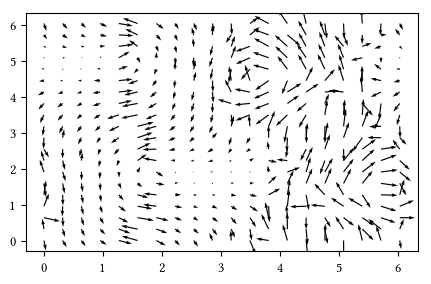

In [65]:
plt.quiver(X[::5,::5],Y[::5,::5],xi2[::5,::5,0,0],xi2[::5,::5,0,1])

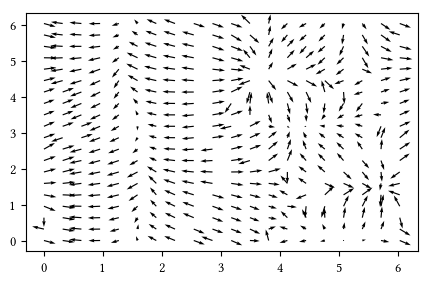

In [67]:
plt.quiver(X[::5,::5],Y[::5,::5],xi3[::5,::5,0,0],xi3[::5,::5,0,1])

In [63]:
X,Y = np.meshgrid(x,y,indexing='ij')

AttributeError: 'list' object has no attribute 'transpose'

In [68]:
xi1[0,0,0]

array([-0.38245475, -0.769654  , -0.51123486])

In [69]:
xi2[0,0,0]

array([ 0.11566538, -0.58882789,  0.79993952])

In [71]:
np.dot(xi1[0,0,0],xi3[0,0,0])

-5.5511151231257827e-17

In [72]:
xi3[0,0,0]

array([ 0.916706  , -0.2468085 , -0.31422235])